# Coursework 3: RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook with your answers. Write your answers in the cells below for each question.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! wget https://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
! mkdir '/content/data_speech_commands_v0.02'
! unzip data_speech_commands_v0.02.zip -d 'data_speech_commands_v0.02'

## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the RNN tutorial: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding
In this part you will have to:

- Implement an LSTM
- Implement a GRU

### Part 2 - Theory

Here you will answer some theoretical questions about RNNs -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

In [11]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "/content/" # this should change depending on where you have stored the data files

### Initial code before coursework questions start:

In [5]:
import math
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

import datetime
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [6]:
import random
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [7]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [12]:
#dataset_folder = "/content/" ## the time is very slow if you do not download. very very very slow.
train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Question 1:  Finalise the LSTM and GRU cells by completing the missing code

You are allowed to use nn.Linear.

In [13]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE - Question 1a) Complete the missing code
        #######################################################################
        self.x2h = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        hx, cx = hx
        
        ########################################################################
        ## START OF YOUR CODE - Question 1b) Complete the missing code
        ########################################################################
        gates = self.x2h(input) + self.h2h(hx)

        input_g, forget_g, cell_g, output_g = gates.chunk(4, 1)

        #four gates
        i_t = torch.sigmoid(input_g)
        f_t = torch.sigmoid(forget_g)
        g_t = torch.tanh(cell_g)
        o_t = torch.sigmoid(output_g)
        
        cy = cx * f_t + i_t * g_t

        hy = o_t * torch.tanh(cy)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        activation = getattr(nn.functional, self.nonlinearity)
        hy = activation(self.x2h(input) + self.h2h(hx))

        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE - Question 1c) Complete the missing code
        ########################################################################
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE - Question 1d) Complete the missing code
        ########################################################################
        x_t = self.x2h(input)
        h_t = self.h2h(hx)

        x_reset, x_up, x_new = x_t.chunk(3, 1)
        h_reset, h_up, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_up + h_up)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate 
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

### Question 2:  Finalise the RNNModel and BidirRecurrentModel

In [14]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE - Question 2a) Complete the missing code
        #
        #  Append the appropriate LSTM cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
                
        ########################################################################
        ## END OF YOUR CODE
        ######################################################################## 

        elif mode == 'GRU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2b) Complete the missing code
        #
        #  Append the appropriate GRU cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################        
        
        elif mode == 'RNN_TANH':
            
                    
        ########################################################################
        ## START OF YOUR CODE - Question 2c) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


                
        elif mode == 'RNN_RELU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2d) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input_data, hx=None):

        outs = []
        X = list(input_data.permute(1, 0, 2))
        h0 = [None] * self.num_layers if hx is None else list(hx)
        
        # In this forward pass we want to create our RNN from the rnn cells,
        # ..taking the hidden states from the final RNN layer and passing these 
        # ..through our fully connected layer (fc).
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE - Question 2e) Complete the missing code
        #
        #  HINT: You may need a special case for LSTMs
        ########################################################################

        for j, l in enumerate(self.rnn_cell_list):
            # Define the first value of hx_minus_one
            hx_minus_one = h0[j]
            for i in range(input_data.shape[1]):
                hx = l(X[i], hx_minus_one)
                hx_minus_one = hx
                X[i] = hx
                if self.mode == 'LSTM':
                  X[i], _ = hx

        outs = X
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        out = outs[-1].squeeze()

        out = self.fc(out)
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE - Question 2f) Complete the missing code
        #
        #  Create code for the following 'mode' values:
        # 'LSTM', 'GRU', 'RNN_TANH' and 'RNN_RELU'
        ########################################################################
        if mode == 'LSTM':
        
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
                
            self.rnn_cell_list_rev.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list_rev.append(LSTMCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))
            self.rnn_cell_list_rev.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for l in range(1, self.num_layers):
                self.rnn_cell_list_rev.append(GRUCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))
                
            self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
                

            self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for l in range(1, self.num_layers):
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))

        else:
            raise ValueError("Invalid RNN mode selected.")

        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input_data, hx=None):
        
        # In this forward pass we want to create our Bidirectional RNN from the rnn cells,
        # .. taking the hidden states from the final RNN layer with their reversed counterparts
        # .. before concatening these and running them through the fully connected layer (fc)
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE  - Question 2g) Complete the missing code
        ########################################################################

        
        h0 = [None] * self.num_layers if hx is None else list(hx)
        hT = [None] * self.num_layers if hx is None else list(hx)

        outs = []
        outs_rev = []

        X = list(input_data.permute(1, 0, 2))
        XT = list(reversed(X))


        for j, l in enumerate(self.rnn_cell_list):
            hx_minus_one = h0[j]

            for i in range(input_data.shape[1]):

                hx = l(X[i], hx_minus_one)
                hx_minus_one = hx
                X[i] = hx
                if self.mode == 'LSTM':
                  X[i], _ = hx

        outs = X

        for j, l in enumerate(self.rnn_cell_list_rev):
            hxt_minus_one = hT[j]

            for i in range(input_data.shape[1]):

                hx = l(XT[i], hxt_minus_one)
                hxt_minus_one = hx
                XT[i] = hx
                if self.mode == 'LSTM':
                  XT[i], _ = hx

        outs_rev = XT

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

The code below trains a network based on your code above. This should work without error:

In [25]:
import time
import datetime
start = datetime.datetime.now() # TIME

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 128
layer_dim = 3
bias = True

### Change the code below to try running different models:
#model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.00666
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)
        loss = criterion(outputs, labels)
        

        if torch.cuda.is_available():
            loss.cuda()
        
        loss.backward()
        
        optimizer.step()
        
        loss_list.append(loss.item())
        iter += 1
        
        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct // total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct // total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))


end = datetime.datetime.now()
total_run_time = end - start
print(total_run_time)

Iteration: 20. Loss: 1.1405329704284668. V-Accuracy: 52  T-Accuracy: 53
Iteration: 40. Loss: 0.6883160471916199. V-Accuracy: 68  T-Accuracy: 67
Iteration: 60. Loss: 0.5213497281074524. V-Accuracy: 70  T-Accuracy: 69
Iteration: 80. Loss: 0.4629509449005127. V-Accuracy: 75  T-Accuracy: 75
Iteration: 100. Loss: 0.4046543836593628. V-Accuracy: 84  T-Accuracy: 83
Iteration: 120. Loss: 0.5473971962928772. V-Accuracy: 83  T-Accuracy: 83
Iteration: 140. Loss: 0.31320905685424805. V-Accuracy: 87  T-Accuracy: 87
Iteration: 160. Loss: 0.2577251195907593. V-Accuracy: 86  T-Accuracy: 87
Iteration: 180. Loss: 0.35502928495407104. V-Accuracy: 83  T-Accuracy: 87
Iteration: 200. Loss: 0.26939722895622253. V-Accuracy: 87  T-Accuracy: 88
Iteration: 220. Loss: 0.2666100263595581. V-Accuracy: 90  T-Accuracy: 90
Iteration: 240. Loss: 0.20458273589611053. V-Accuracy: 91  T-Accuracy: 90
Iteration: 260. Loss: 0.15508081018924713. V-Accuracy: 90  T-Accuracy: 90
Iteration: 280. Loss: 0.24855293333530426. V-Accur

## Part 2: Theoretical questions

#### Theory question 1: 
What is the _vanishing gradients problem_ and why does it occur? Which activation functions are more or less impacted by this, and why?

#### Your answers:
* Your answer here describing vanishing gradients problem
* Two examples of activation functions more impacted by vanishing gradients
* Two examples of activation functions less impacted by vanishing gradients, why are they impacted less?


1). vanishing gradients : 
During the training process, when the gradients of the loss function (corresponding to the parameters of the net) become smaller and smaller (near to 0), the vanishing gradients happen. With just a small (near to 0) gradient, the parameters in the net will almost not update, which means the net will not update and stop learning.

The reason for vanishing gradients: when lots of activation functions(such as sigmoid and tanh) were sequentially used in a deep network, the vanishing gradients (or exploding gradients) might happen. Due to the chain rule, in a net with N layers, after N times multiplying with small values(the absolute value is smaller than 1), the magnitude of the update will decrease exponentially.

2). Two examples more impacted. Sigmoid, TANH.

3). Two examples less impacted. ReLU, Leaky ReLU.

In the saturation region of the sigmoid and tanh functions, the function value changes very slowly. In this region, the derivative approaches zero. Besides, the absolute value of the function is also less than 1, and consecutive multiples may cause the gradient to disappear. But for the relu function, when x is greater than 0, the derivative of the function is equal to 1, and the value of the function is x, which avoids consecutive multiples gets zero to a certain extent. But when x is less than 0, the value of Relu is zero, which means that there is still the possibility of the gradient vanishing. Leakey relu avoids this situation to a certain extent. When x is greater than 0, it is the same as relu. When x is less than 0, the derivative is not 0 but is equal to a smaller value (0.1, 0.2, or adjusted according to the learning progress).




#### Theory question 2: 
Why do LSTMs help address the vanishing gradient problem compared to a vanilla RNN?

The Gate.

For LSTM, there is an equation:
\begin{equation}
C_{t}=f_{t} * C_{t-1}+i_{t} * \tilde{C}_{t}
\end{equation}

From our class we could get the $\frac{\partial C_{t}}{\partial C_{t-1}}$ :

\begin{equation}
\frac{\partial C_{t}}{\partial C_{t-1}}=\frac{\partial C_{t}}{\partial f_{t}} \frac{\partial f_{t}}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial C_{t-1}}+\frac{\partial C_{t}}{\partial i_{t}} \frac{\partial i_{t}}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial C_{t-1}}+\frac{\partial C_{t}}{\partial C_{t-1}^{-}} \frac{\partial C_{t-1}}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial C_{t-1}}+\frac{\partial C_{t}}{\partial C_{t-1}}
\end{equation}

\begin{equation}
\frac{\partial C_{t}}{\partial C_{t-1}}=C_{t-1} \sigma^{\prime}(.) W_{f} * o_{t-1} \tanh \left(C_{t-1}\right)+\tilde{C}_{t} \sigma^{\prime}(.) W_{i} * o_{t-1} \tanh \left(C_{t-1}\right)+i_{t} \tanh ^{\prime}(.) W_{c} * o_{t-1} \tanh \left(C_{t-1}\right)+f_t
\end{equation}

Now, let's notice the difference between LSTM and RNN. For RNN, the value of $\frac{\partial h_{t}}{\partial h_{t-1}}$ will always locate in [0,1] or greater than 1,which could lead to the vanishing gradient problem( or exploding ). But if there are a huge amount time steps for LSTM, the LSTM net will not convert to 0 or infinity. When LSTM has the trend to convert to 0, the $f_t$ will be increased and let the $\frac{\partial C_{t}}{\partial C_{t-1}}$ to near to 1. In this way, the vanishing gradient could be prevented.

#### Theory question 3: 

The plot below shows the training curves for three models A, B, and C, trained on the same dataset up to 100 epochs. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.

(In the cell below please set the values for A_model, B_model and C_model to be 'RNN', 'LSTM' or 'GRU'. This needs to be exact for the automatic marking.)

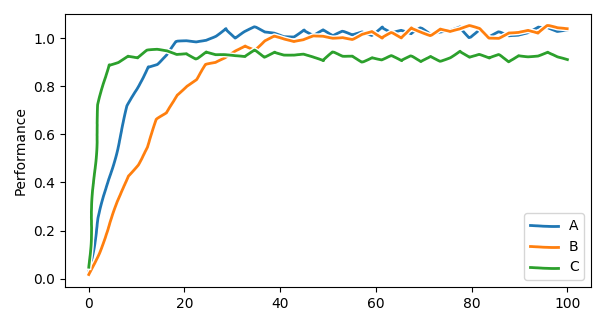

In [ ]:
from IPython.display import Image, display
display(Image(filename='Performance by epoch.png', width=550))

In [ ]:
# Answers below:

A_model = 'GRU'
B_model = 'LSTM'
C_model = 'RNN'

# Give your reasons below:


**C is RNN**: 
It is obvious that the C is RNN. The performance increased dramatically and became smooth firstly. These phenomenons means that the gradient vanishing happend quickly, which means that the model C does not have the forget gates like GRU and LSTM. And the performance is the worst among the three model.

**B is LSTM**, **A is GRU**:
One of the differences between GRU and LSTM is that GRU has less parameters(75% of LSTM). So compared with GRU, LSTM needs more epoch(time) to train to get the best performance. So A is GRU and B is LSTM.



#### Theory question 4: 

When might you choose to use each of the three different types of models?

#### Your answers:
* Type of problem when best to use vanilla RNN:
* Type of problem to use GRU:
* Type of problem to use LSTM:


RNN: the problem that is not complex and that does not include long-time-range correlation data in its inputs.

GRU: If the time and resources are not enough, (for example, in some cases we need to perform rapid iterations for our products) GRU might be a good choice, because GRU has fewer parameters and its architecture is simpler than LSTM, which allows people to tune and code quickly. 


LSTM: The "memory" cell of LSTM is independent, while the "memory" cell of GRU is controlled by the update gate. From theory, LSTM cells should remember longer sequences than GRUs. So LSTM might be chosen to deal with some difficult problems. For example, the input contains a huge amount of long data, or the problem needs to deal with very long-time-range correlation data. 